# **Final Project**
## *Emily Philippides*
### SML 310 

In [ ]:
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import scipy 
import seaborn as sns
from google.colab import drive
import time
drive.mount('drive')
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, precision_recall_curve, roc_curve, roc_auc_score, precision_score, recall_score, fbeta_score, f1_score
from sklearn.naive_bayes import GaussianNB as NB
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.tree import DecisionTreeClassifier as DT
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.linear_model import Lasso

Mounted at drive


In [ ]:
# For drawing map
!pip install plotly-geo
!pip install pyshp
!pip install shapely
!pip install fiona
!pip install six
!pip install pyproj
!pip install geopandas
!pip install plotting
import geopandas
import shapely
import shapefile
import plotly
from plotly.figure_factory._county_choropleth import create_choropleth
import xlrd
import plotly.figure_factory as ff
import warnings

# Helper Functions

In [ ]:
# Class to format text when printed (color, bolded, underlined, italicized)
# Code taken from: https://stackoverflow.com/questions/8924173/how-do-i-print-bold-text-in-python/8930747
class font:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   ITALICS = '\x1B[3m'
   END = '\033[0m'

In [ ]:
# Code execution timer
# Code taken from: https://www.codespeedy.com/how-to-create-a-stopwatch-in-python/
def time_convert(sec):
    mins = sec // 60
    sec = sec % 60
    hours = mins // 60
    mins = mins % 60
    return ("Time Lapsed = {}:{}:{}".format(int(hours), int(mins), int(sec)))
    
start_time = time.time()

In [ ]:
# Get range of values of each column in specified dataframe
def get_ranges(df):
    neg_numbers = []
    df = df.select_dtypes(include=np.number)
    for col in df.columns:
        print('{} range:'.format(col).ljust(40), '[{}, {}]'.format(df[col].min(), df[col].max()).ljust(45))
        if df[col].min() < 0:
            neg_numbers.append(col)
    return neg_numbers

In [ ]:
# Remove rows with strange values in any column
def remove_nonsensical(df, neg_cols):
    for col in neg_cols:
        df = df[df[col] > 0]

    display(df)
    return df

In [ ]:
# Convert ZIP codes to FIPS codes
def format_zip(df):
    arr = np.array(df['property_zip'].unique())
    dtypes = np.array([is_number(s) for s in arr])

    print(arr[~dtypes])

    for zip in arr[~dtypes]:
        df = df[df['property_zip'] != zip]

    df['property_zip'] = df['property_zip'].astype(int)

    return df

In [ ]:
# Count the number of null values in each column and each row
def count_null(df, thresh):
    print('Columns = {}. Rows = {}.'.format(df.shape[1], df.shape[0]))
    t = str(int(thresh*100))

    null_rows = df.isnull().sum(axis=1).values
    fiftyp_rows = null_rows/len(df.columns)
    fiftyp_rows = len(fiftyp_rows[fiftyp_rows>thresh])
    print('There are no rows with more than {} NaN columns. {} rows have more than {}% NaN columns.'.format(null_rows.max(), fiftyp_rows, t))

    null_cols = df.isnull().sum(axis=0).values
    fiftyp_cols = null_cols/len(df)
    fiftyp_cols = len(fiftyp_cols[fiftyp_cols>thresh])
    print('There are no columns with more than {} NaN rows. {} columns have more than {}% NaN rows. \n'.format(null_cols.max(), fiftyp_cols, t))

    return

In [ ]:
# Remove columns with > x NaN values in the rows
def drop_columns(df, thresh):
    print('Shape before: {}'.format(df.shape))
    cutoff = len(df) * thresh
    df = df.drop(columns = (df.columns[df.isna().sum().values > cutoff]))
    print('Shape after: {} \n'.format(df.shape))
    return df

In [ ]:
# Count number of instances of each unique loan
def add_loan_counts(df):
    df['one'] = 1
    counts_df = df.groupby(by=['loan_id'])[['one']].sum().reset_index()
    counts_df.columns = ['loan_id', 'id_count']
    df = df.merge(counts_df, on='loan_id', how='inner', validate='many_to_one')
    df = df.drop(columns=['one'])
    return df

In [ ]:
# Check whether a condition is met in the data
def data_checker(condition, df):
    ids = df.loc[~condition, 'loan_id'].unique()
    number = 0
    for id in ids:
        number += len(df[df['loan_id'] == id])

    print('Expecting deletion of... {} rows'.format(number))
    print('Deleting... {} rows'.format(len(df[~condition])))

    return df[condition]

In [ ]:
# Convert output to binary indicator for classification
def format_output_var(y, output_var):
    y.loc[y[output_var] != 'C', output_var] = 0
    y.loc[y[output_var] == 'C', output_var] = 1
    y[output_var] = y[output_var].astype(int)
    return y

In [ ]:
# Convert date in format provided by CoreLofic to {year, month} format
def format_date(df, all_years, all_months):
    col_name = 'next_period_of_payment'
    df[col_name] = ''
    for year in all_years:
        for number in year:
            index = year.index(number)
            df.loc[df['period_of_payment'] == number, col_name] = all_months[year.index(number)]
    
    df[col_name] =  df['year'].astype(int).astype(str) + ' ' + df[col_name]

    return df

In [ ]:
# Check if a string is a number or unicode character
# Code taken from: https://www.pythoncentral.io/how-to-check-if-a-string-is-a-number-in-python-including-unicode/
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

In [ ]:
# Perform one-hot encoding of unique string values
# Must deal with mixed datatypes in some of the columns
def one_hot(train, test, col_list): 
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    for i in col_list:
        for df in [train, test]:
            arr = np.array(df[i].unique())
            dtypes = np.array([is_number(s) for s in arr])
            for uv in arr[dtypes]:
                df.loc[df[i] == uv, i] = df.loc[df[i] == uv, i].astype(float).astype(int).astype(str)
            for uv in arr[~dtypes]:
                df.loc[df[i] == uv, i] = df.loc[df[i] == uv, i].astype(str)

        unique_vals = np.unique(list(train[i].unique()) + list(test[i].unique()))
        print(i, unique_vals)
        unique_vals = unique_vals[:-1]
            
        for x in unique_vals:
            for df in [train, test]:
                df[i + '_' + x] = df[i].str.contains(x).astype(int).values

    train = train.drop(columns = col_list)
    test = test.drop(columns = col_list)

    return train, test

In [ ]:
# Function that tunes model hyperparameters and performs feature selection to further reduce the feature space
# Code taken from: Mini-Project #2
def tuning(X_train, y_train, X_test, y_test, space, model): 
    print(font.RED + font.BOLD + font.UNDERLINE + str(model).split('(')[0] + font.END)

    # Tune hyperparameters of Lasso feature selector and model, using 3-fold cross validation
    pipeline = Pipeline([('sfm', SelectFromModel(estimator=Lasso(random_state=42, max_iter=1000), max_features=None)),
                         ('clf', model)])
    search = GridSearchCV(pipeline, space, scoring='accuracy', cv=3, error_score='raise').fit(X_train, y_train)

    # Results of hyperparameter tuning: hyperparamaters that gave the lowest neg mean absolute error on the training dataset
    # Will return these hyperparameters for use in fitting the model outside this function
    print('Best hyperparameters: ', search.best_params_)

    # Results of feature selection
    sfm = SelectFromModel(Lasso(alpha=search.best_params_['sfm__estimator__alpha']))
    sfm.fit(X_train, y_train)
    print('Features:', X_train.columns[sfm.get_support()].values)
    Xtrain_new = sfm.transform(X_train) # get training dataframe with selected features
    Xtest_new = sfm.transform(X_test) # get testing dataframe with selected features
    print('Shape of training set before/after FS:', X_train.shape, '->', Xtrain_new.shape, '\nShape of testing set before/after FS:', X_test.shape, '->', Xtest_new.shape)

    return Xtrain_new, Xtest_new, search.best_params_

In [ ]:
# Function that takes in y_test values and prediction values, and prints various evaluation metrics
def get_metrics(y, pred, type):
    print(font.RED + '\nPerformance on {} data:'.format(type) + font.END)
    print(font.BLUE + 'Accuracy:' + font.END, accuracy_score(y, pred).round(3))
    print(font.BLUE + 'Precision:'  + font.END, precision_score(y, pred).round(3))
    print(font.BLUE + 'Recall:'  + font.END, recall_score(y, pred).round(3))
    print(font.BLUE + 'F1 Score:'  + font.END, f1_score(y, pred).round(3))
    print(font.BLUE + 'F2 Score:'  + font.END, fbeta_score(y, pred, beta=2).round(3))

    # Confusion matrix visualization
    cm = confusion_matrix(y, pred)
    print(font.BLUE + 'Confusion Matrix:' + font.END)
    # Code below adapted from: https://maxbox4.wordpress.com/2020/05/01/confusion-matrix-explained/
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(cm)
    ax.grid(False)
    ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Neg', 'Predicted Pos'))
    ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Neg', 'Actual Pos'))
    for i in range(2):
        for j in range(2):
            text = str(cm[i, j]) + ' (' + str(round(cm[i, j]/len(pred), 3)) + ')'
            ax.text(j, i, text, ha='center', va='center', color='white', fontsize='large', fontweight='bold')
    plt.show()
    tn, fp, fn, tp = cm.ravel()
    print(font.BLUE + 'Rates:'  + font.END, 'TNR:', (tn/(tn+fp)).round(2), '| TPR:', (tp/(tp+fn)).round(2), '| FNR:', (fn/(tp+fn)).round(2), '| FPR:', (fp/(fp+tn)).round(2))

    # Residuals
    return np.abs(y - pred)

# Load Data

In [ ]:
# Load and concatenate all datasets
# Data is from CoreLogic but appended and concatenated in a separate .ipynb notebook
# NOTE: To run models, skip directly to "Machine Learning Implementation" section
for date in list(np.arange(229, 241, 1).astype(str)):
    filename = 'MERGED_{}_NY.csv'.format(date)
    path = '/content/drive/MyDrive/Thesis/Merged_Data/' + filename 
    merged_df = pd.read_csv(path, low_memory=False) if date == '229' else pd.concat([merged_df, pd.read_csv(path, low_memory=False)])

In [ ]:
orig_ny = pd.read_csv('/content/drive/MyDrive/Thesis/Merged_Data/ORIGINATION_NY.csv', low_memory=False)

# Sort dataframe by loan id, year, and loan age
merged_df = merged_df.sort_values(['loan_id', 'year', 'loan_age'])
merged_df

,Unnamed: 0,loan_id,current_balance,current_interest_rate,total_payment_due,scheduled_principal,scheduled_monthly_pi,mba_delinquency_status,mba_days_delinquent,active_status,period_of_payment,current_investor_code,current_product_type,loan_age,mba_worst_ever,bk_flag,year,add_date,property_zip,state,property_type,number_of_units,occupancy_type,original_balance,appraised_value,product_type,original_term,initial_interest_rate,loan_type,loan_purpose,payment_frequency,channel,buydown_flag,documentation_type,pool_insurance_flag,original_ltv,fico_score_at_origination,prepay_penalty_flag,cbsa,io_flag,msa,paid_off_flag,inferred_collateral_type,collateral_type,orig_active_status,period,product_type_category,loan_purpose_category,mortgage_insurance_flag,gse_eligible_flag
74151,685118933,223163030,287914.63,7.950,2110.52,203.09,2110.51,C,0.0,A,231.0,NaN,10,1.0,0.0,N,2008,229,10308,NY,1,1.0,1.0,289000.0,NaN,10,360.0,7.950,1.0,1.0,4.0,1,N,1.0,N,62.80,637.0,N,35614.0,NaN,254.0,N,S,S,RI,315,F,P,N,1.0
74152,685118934,223163030,287322.06,7.950,2110.52,207.02,2110.51,C,0.0,A,232.0,NaN,10,2.0,0.0,N,2008,229,10308,NY,1,1.0,1.0,289000.0,NaN,10,360.0,7.950,1.0,1.0,4.0,1,N,1.0,N,62.80,637.0,N,35614.0,NaN,254.0,N,S,S,RI,315,F,P,N,1.0
74153,685118935,223163030,286125.13,7.950,2110.52,214.95,2110.51,C,0.0,A,233.0,NaN,10,3.0,0.0,N,2008,229,10308,NY,1,1.0,1.0,289000.0,NaN,10,360.0,7.950,1.0,1.0,4.0,1,N,1.0,N,62.80,637.0,N,35614.0,NaN,254.0,N,S,S,RI,315,F,P,N,1.0
74154,685118936,223163030,283625.13,7.950,2110.52,231.51,2110.51,C,0.0,A,234.0,NaN,10,4.0,0.0,N,2008,229,10308,NY,1,1.0,1.0,289000.0,NaN,10,360.0,7.950,1.0,1.0,4.0,1,N,1.0,N,62.80,637.0,N,35614.0,NaN,254.0,N,S,S,RI,315,F,P,N,1.0
74155,685118937,223163030,284270.71,7.950,2110.52,227.23,2110.51,C,0.0,A,235.0,NaN,10,5.0,0.0,N,2008,229,10308,NY,1,1.0,1.0,289000.0,NaN,10,360.0,7.950,1.0,1.0,4.0,1,N,1.0,N,62.80,637.0,N,35614.0,NaN,254.0,N,S,S,RI,315,F,P,N,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275361,655327178,1197970209,331287.15,3.457,6981.96,922.55,1876.42,C,0.0,I,342.0,NaN,20,115.0,0.0,N,2017,240,10459,NY,1,3.0,1.0,395000.0,565000.0,20,360.0,8.393,1.0,2.0,4.0,3,Y,2.0,NaN,69.91,701.0,N,35614.0,N,254.0,Y,P,P,RI,315,A,R,N,1.0
275362,655327179,1197970209,330364.61,3.716,7004.39,853.85,1920.81,C,0.0,I,343.0,NaN,20,116.0,0.0,N,2017,240,10459,NY,1,3.0,1.0,395000.0,565000.0,20,360.0,8.393,1.0,2.0,4.0,3,Y,2.0,NaN,69.91,701.0,N,35614.0,N,254.0,Y,P,P,RI,315,A,R,N,1.0
275364,655327181,1197970209,329510.77,3.776,7041.93,840.22,1931.24,C,0.0,I,344.0,NaN,20,117.0,0.0,N,2017,240,10459,NY,1,3.0,1.0,395000.0,565000.0,20,360.0,8.393,1.0,2.0,4.0,3,Y,2.0,NaN,69.91,701.0,N,35614.0,N,254.0,Y,P,P,RI,315,A,R,N,1.0
275366,655327183,1197970209,328670.57,3.838,7041.93,825.84,1942.31,C,0.0,I,345.0,NaN,20,118.0,0.0,N,2017,240,10459,NY,1,3.0,1.0,395000.0,565000.0,20,360.0,8.393,1.0,2.0,4.0,3,Y,2.0,NaN,69.91,701.0,N,35614.0,N,254.0,Y,P,P,RI,315,A,R,N,1.0


# Clean Data

In [ ]:
output_var = 'mba_delinquency_status'

In [ ]:
# Drop unnecessary features
cols_to_drop = [x.startswith('Unnamed:') for x in np.array(merged_df.columns)]
cols_to_drop = cols_to_drop
merged_df = merged_df.loc[:, ~np.array(cols_to_drop)]

# Drop features that would be unavailable for prediction (i.e. after the loan had been paid off)
merged_df = merged_df.drop(columns=['orig_active_status', 'paid_off_flag'])

In [ ]:
# Observe range of values per feature
neg_cols = get_ranges(merged_df)

loan_id range:                           [223163030, 1197970209]                      
current_balance range:                   [0.01, 9969942.76]                           
current_interest_rate range:             [1.25, 13.38]                                
total_payment_due range:                 [2.4, 64428.07]                              
scheduled_principal range:               [0.01, 999999.0]                             
scheduled_monthly_pi range:              [1.59, 1956309.34]                           
mba_days_delinquent range:               [0.0, 180.0]                                 
period_of_payment range:                 [229.0, 372.0]                               
current_investor_code range:             [240.0, 253.0]                               
loan_age range:                          [1.0, 365.0]                                 
mba_worst_ever range:                    [0.0, 180.0]                                 
year range:                              [2

In [ ]:
# Format current date
year_2008 = [229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240]
year_2009 = list(np.array(year_2008) + 12)
year_2010 = list(np.array(year_2009) + 12)
year_2011 = list(np.array(year_2010) + 12)
year_2012 = list(np.array(year_2011) + 12)
year_2013 = list(np.array(year_2012) + 12)
year_2014 = list(np.array(year_2013) + 12)
year_2015 = list(np.array(year_2014) + 12)
year_2016 = list(np.array(year_2015) + 12)
year_2017 = list(np.array(year_2016) + 12)
year_2018 = list(np.array(year_2017) + 12)
year_2019 = list(np.array(year_2018) + 12)

all_years = [year_2008, year_2009, year_2010, year_2011, year_2012, year_2013, year_2014, year_2015, year_2016, year_2017, year_2018, year_2019]
all_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']

merged_df = format_date(merged_df, all_years, all_months)

In [ ]:
# Shift 'performance' features back by one
cols_to_shift = ['current_balance', 'current_interest_rate',
                'total_payment_due', 'scheduled_principal', 
                'scheduled_monthly_pi', 'mba_days_delinquent', 
                'active_status', 'period_of_payment',
                'current_investor_code', 'current_product_type',
                'mba_worst_ever', 'bk_flag']

for col in cols_to_shift:
    merged_df[col] = merged_df.groupby('loan_id')[col].shift(1)

In [ ]:
# Count nulls
count_null(merged_df, 0.5)
count_null(merged_df, 0.9)

Columns = 48. Rows = 1915111.
There are no rows with more than 24 NaN columns. 0 rows have more than 50% NaN columns.
There are no columns with more than 1623143 NaN rows. 2 columns have more than 50% NaN rows. 

Columns = 48. Rows = 1915111.
There are no rows with more than 24 NaN columns. 0 rows have more than 90% NaN columns.
There are no columns with more than 1623143 NaN rows. 0 columns have more than 90% NaN rows. 



In [ ]:
# Observe how many nulls per features
merged_df.isnull().sum(axis=0)

loan_id                            0
current_balance                46265
current_interest_rate          46308
total_payment_due              46265
scheduled_principal            46265
scheduled_monthly_pi           46265
mba_delinquency_status             1
mba_days_delinquent            46265
active_status                  46265
period_of_payment              46265
current_investor_code         247451
current_product_type           46265
loan_age                           0
mba_worst_ever                 46384
bk_flag                        46265
year                               0
add_date                           0
property_zip                       0
state                              0
property_type                  18613
number_of_units                 1274
occupancy_type                 16572
original_balance                   0
appraised_value              1552541
product_type                     607
original_term                      0
initial_interest_rate             13
l

In [ ]:
# Remove cols with > 50% NaN values in the columns
thresh = len(merged_df) * 0.5
merged_df = merged_df.drop(columns = (merged_df.columns[merged_df.isna().sum().values > thresh]))

count_null(merged_df, 0.50)

Columns = 46. Rows = 1915111.
There are no rows with more than 22 NaN columns. 0 rows have more than 50% NaN columns.
There are no columns with more than 291358 NaN rows. 0 columns have more than 50% NaN rows. 



In [ ]:
# Observe how many nulls per features
merged_df.isnull().sum(axis=0)

loan_id                           0
current_balance               46265
current_interest_rate         46308
total_payment_due             46265
scheduled_principal           46265
scheduled_monthly_pi          46265
mba_delinquency_status            1
mba_days_delinquent           46265
active_status                 46265
period_of_payment             46265
current_investor_code        247451
current_product_type          46265
loan_age                          0
mba_worst_ever                46384
bk_flag                       46265
year                              0
add_date                          0
property_zip                      0
state                             0
property_type                 18613
number_of_units                1274
occupancy_type                16572
original_balance                  0
product_type                    607
original_term                     0
initial_interest_rate            13
loan_type                         0
loan_purpose                

In [ ]:
# Find and remove constant columns
constant_cols = []
for col in merged_df.columns:
    if len(merged_df[col].unique()) == 1:
        constant_cols.append(col)

print('Removing...', constant_cols)
merged_df = merged_df.drop(columns = constant_cols)

Removing... ['state', 'payment_frequency']


In [ ]:
# Check for duplicated rows
if sum(merged_df.duplicated().values) != 0:
    raise ValueError('Must remove duplicate rows.')

In [ ]:
# Convert ZIP codes to FIPS codes
merged_ZIPS = format_zip(merged_df)
ZIPS2FIPS = pd.read_csv('/content/drive/MyDrive/Thesis/Merged_Data/New_York_State_ZIP.csv')[['County FIPS', 'ZIP Code']] # Data from: https://data.ny.gov/Government-Finance/New-York-State-ZIP-Codes-County-FIPS-Cross-Referen/juva-r6g2
ZIPS2FIPS.columns = ['property_fips', 'property_zip']
merged_ZIPS = merged_ZIPS.merge(ZIPS2FIPS, on='property_zip', how='inner')
FIPS2RUCC = pd.read_csv('/content/drive/MyDrive/codes.csv') # Data from: https://www.ers.usda.gov/data-products/rural-urban-continuum-codes.aspx
FIPS2RUCC = FIPS2RUCC.dropna(how='all')
FIPS2RUCC['property_fips'] = FIPS2RUCC['FIPS'].astype(int).values
merged_ZIPS = merged_ZIPS.merge(FIPS2RUCC, on='property_fips', how='inner')
merged_ZIPS = format_output_var(merged_ZIPS, output_var)
merged_ZIPS['RUCC_2013'] = -merged_ZIPS['RUCC_2013'] + 9

merged_df = merged_df.drop(columns=['property_zip'])

['NY000']


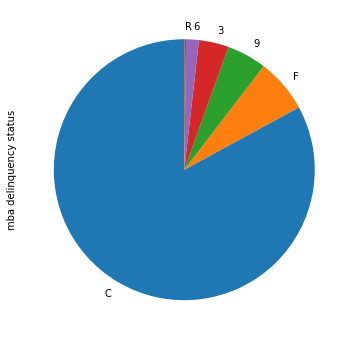

In [ ]:
# Visualize distribution of output variable
merged_df[output_var].value_counts().plot(kind='pie', figsize=(6, 6), startangle=90, ylabel=output_var.replace("_", " "));
plt.savefig('pie_plot.png', bbox_inches='tight', dpi=200, transparent=False)

In [ ]:
# Train / test split by loan ID
d = {'loan_id': merged_df['loan_id'].unique()}
df = pd.DataFrame(data=d)
df['int'] = np.arange(len(df))

print('Before:', len(merged_df))
merged_df = merged_df.merge(df, on='loan_id', how='inner', validate='many_to_one')
print('After:', len(merged_df))

full_train = merged_df.loc[merged_df['int'] < len(df)/2, :].reset_index().drop(columns=['index', 'int'])
full_test = merged_df.loc[merged_df['int'] >= len(df)/2, :].reset_index().drop(columns=['index', 'int'])

Before: 1915111
After: 1915111


# EDA

In [ ]:
# sns.pairplot(merged_df);

In [ ]:
# Plot styling
font_ax = {'size' : 10, 'family' : 'sans'}
font_title = {'family' : 'sans', 'weight' : 'bold', 'size' : 14}
colors = ['purple', 'darkorange', 'royalblue', 'deeppink', 'green']

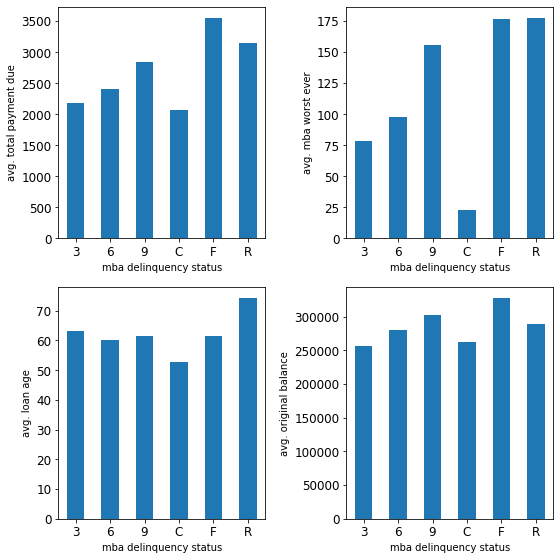

In [ ]:
# Group data by output type, and find average of each column
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
columns = ['total_payment_due', 'mba_worst_ever', 'loan_age', 'original_balance']

for i in columns:
    df_bygroup = full_train[[i, output_var]].groupby([output_var]).mean().transpose()
    if i == columns[0]:
        grouped_data = df_bygroup.copy()
    else:
        grouped_data = grouped_data.append(df_bygroup)

# Display results via bar plots
fig, axs = plt.subplots(2, 2, figsize=(8,8))
ax1 = 0
ax2 = 0
gdt = grouped_data.transpose().reset_index()
for i in columns:
    gdt.plot.bar(x=output_var, y=i, xlabel=output_var.replace("_", " "), ylabel='avg. {}'.format(i.replace("_", " ")), ax=axs[ax1, ax2], fontsize=12, rot=.01, legend=None)

    fig.tight_layout(pad=1.5)
    ax2 += 1
    if ax2 == 2:
        ax2 = 0
        ax1 += 1

plt.savefig('bar_graph.png', bbox_inches='tight', dpi=200, transparent=False)

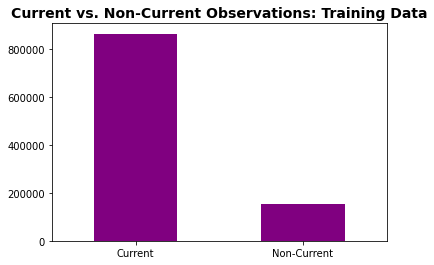

In [ ]:
# Convert output to binary for classification problem
full_train = format_output_var(full_train, output_var)
full_test = format_output_var(full_test, output_var)

ax = full_train[output_var].value_counts().plot(kind='bar', rot=0, color='purple')
ax.set_title('Current vs. Non-Current Observations: Training Data', **font_title)
ax.set_xticklabels(['Current', 'Non-Current']);
plt.savefig('c_vs_nc.png', bbox_inches='tight', dpi=200, transparent=False)

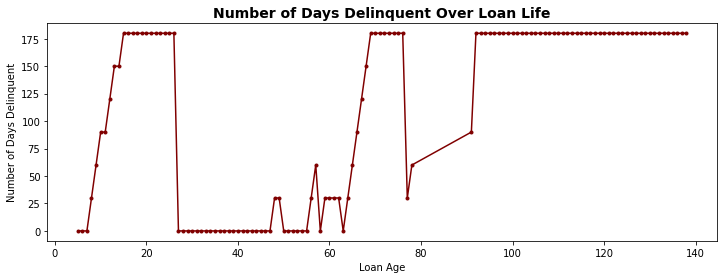

In [ ]:
# Count the number of occurances of each loan
full_train_wcounts = add_loan_counts(full_train)
condition = (full_train_wcounts['id_count'] > 12*10) & (full_train_wcounts['mba_days_delinquent'] == 30)
loan_to_plot = full_train_wcounts.loc[condition, 'loan_id'].unique()[0]

loan_df = full_train_wcounts.loc[full_train_wcounts['loan_id'] == loan_to_plot, :]

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(loan_df['loan_age'], loan_df['mba_days_delinquent'].values, 'bo-', color='maroon', linewidth=1.5, markersize=3)       
ax.set_xlabel("Loan Age", **font_ax)
ax.set_ylabel("Number of Days Delinquent", **font_ax)
ax.set_title("Number of Days Delinquent Over Loan Life", **font_title);
plt.savefig('days_dq.png', bbox_inches='tight', dpi=200, transparent=False)

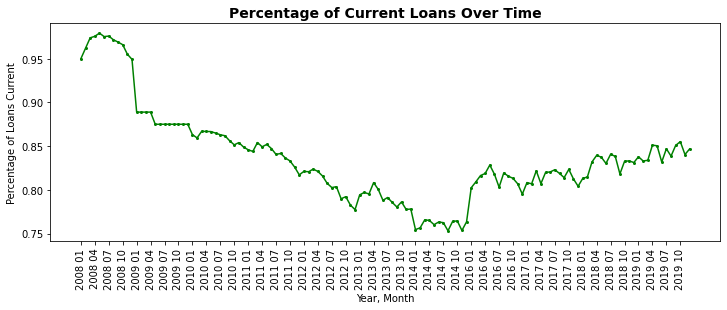

In [ ]:
# Plot delinquency rate of mortgages in training dataframe over time
grouped_year = full_train.groupby('next_period_of_payment').sum()/full_train.groupby('next_period_of_payment').count()
grouped_year = grouped_year.reset_index()

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(grouped_year['next_period_of_payment'], grouped_year['mba_delinquency_status'].values, 'bo-', color='green', linewidth=1.5, markersize=2)       
ax.set_xlabel("Year, Month", **font_ax)
ax.set_ylabel("Percentage of Loans Current", **font_ax)
ax.set_title("Percentage of Current Loans Over Time", **font_title)
plt.draw()
labels = []
for label in ax.get_xticklabels()[::3]:
    labels.append(label.get_text())
ax.set_xticks(ax.get_xticks()[::3])
ax.set_xticklabels(labels, rotation=90);
plt.savefig('%current.png', bbox_inches='tight', dpi=200, transparent=False)

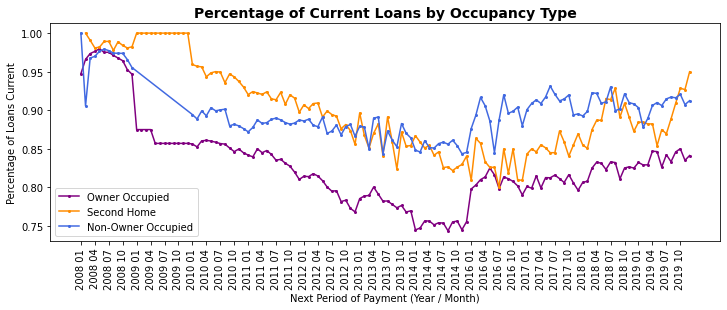

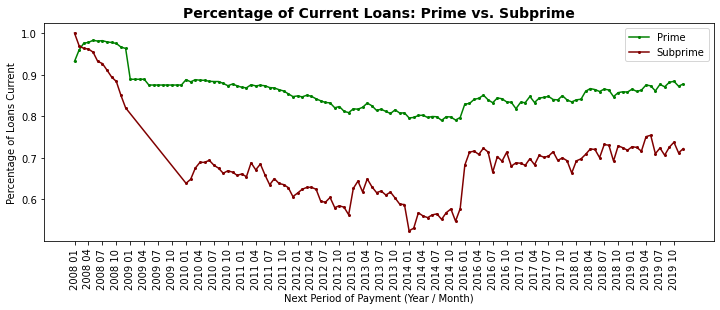

In [ ]:
# Function to make time plot given dataframe and y variable
def make_plot(df, i, title, colors, legend):
    df = df.dropna(subset = [i])
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    arr = np.array(df[i].unique())
    dtypes = np.array([is_number(s) for s in arr])

    for uv in arr[dtypes]:
        df.loc[df[i] == uv, i] = df.loc[df[i] == uv, i].astype(float).astype(int).astype(str)
    for uv in arr[~dtypes]:
        df.loc[df[i] == uv, i] = df.loc[df[i] == uv, i].astype(str)

    unique = df[i].unique()
    unique.sort()

    grouped_df = df.groupby(['next_period_of_payment', i]).sum()/df.groupby(['next_period_of_payment', i]).count()
    grouped_df = grouped_df.reset_index().sort_values(by=['next_period_of_payment'])

    fig, ax = plt.subplots(figsize=(12, 4))
    
    for j in range(len(unique)):
        ax.plot(grouped_df.loc[grouped_df[i] == unique[j], 'next_period_of_payment'].values, 
                grouped_df.loc[grouped_df[i] == unique[j], 'mba_delinquency_status'].values, 
                'bo-', color=colors[j], label=legend.get(unique[j]), linewidth=1.5, markersize=2)       
    ax.legend()
    ax.set_xlabel("Next Period of Payment (Year / Month)", **font_ax)
    ax.set_ylabel("Percentage of Loans Current", **font_ax)
    ax.set_title(title, **font_title)
    plt.draw()
    labels = []
    for label in ax.get_xticklabels()[::3]:
        labels.append(label.get_text())
    ax.set_xticks(ax.get_xticks()[::3])
    ax.set_xticklabels(labels, rotation=90);
    plt.savefig(i + '.png', bbox_inches='tight', dpi=200, transparent=False)


make_plot(df = full_train, 
          i = 'occupancy_type', 
          title = 'Percentage of Current Loans by Occupancy Type', 
          colors = ['purple', 'darkorange', 'royalblue'], 
          legend = {'1': 'Owner Occupied', '2': 'Second Home', '3': 'Non-Owner Occupied'})

# make_plot(df = full_train, 
#           i = 'documentation_type', 
#           title = 'Percentage of Current Loans by Documentation Type', 
#           colors = ['teal', 'deeppink', 'maroon'],
#           legend = {'1': 'Full Documentation', '2': 'Minimal Documentation', '3': 'No Asset/Income Verification'})

make_plot(df = full_train, 
          i = 'inferred_collateral_type', 
          title = 'Percentage of Current Loans: Prime vs. Subprime', 
          colors = ['green', 'maroon'],
          legend = {'P': 'Prime', 'S': 'Subprime'})

# make_plot(df = full_train, 
#           i = 'product_type', 
#           title = 'Percentage of Current Loans by Product Type', 
#           colors = ['green', 'darkorange'],
#           legend = {})

In [ ]:
# Map of change in delinquency rate by NY county
i = 'property_fips'
grouped_fips = merged_ZIPS.groupby([i]).mean().round(2)
grouped_fips = grouped_fips.reset_index()
fips = grouped_fips[i].values.astype(str).tolist()
values = grouped_fips['mba_delinquency_status'].values.astype(str).tolist()

warnings.filterwarnings("ignore")
fig = ff.create_choropleth(scope=['NY'], height=500, width=900, fips=fips, values=values)
fig.layout.template = None
fig.show()
warnings.filterwarnings('always')

In [ ]:
# Map of level of urbanization by NY county
values = grouped_fips['RUCC_2013'].values.astype(str).tolist()

warnings.filterwarnings("ignore")
fig = ff.create_choropleth(scope=['NY'], height=500, width=900, fips=fips, values=values)
fig.layout.template = None
fig.show()
warnings.filterwarnings('always')

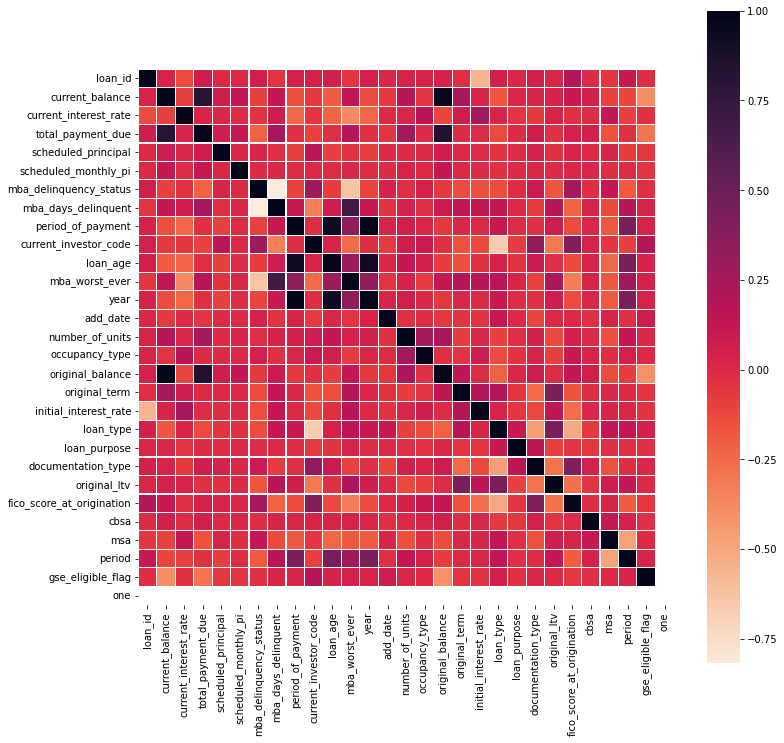

In [ ]:
# Get correlation matrix between all features 
corr_matrix = full_train.corr(method='pearson')
cmap = sns.cm.rocket_r
fig = plt.subplots(figsize=(12,12))
sns.heatmap(corr_matrix, cmap=cmap, square=True, linewidths=0.08); 
plt.savefig('heatmap.png', bbox_inches='tight', dpi=200, transparent=False)

In [ ]:
# Remove highly correlated features
# Code below adapted from my COS424 project in spring 2021

# Ignore diagonal entries
corr_matrix = full_train.corr(method='pearson')
np.fill_diagonal(corr_matrix.values, 0)

# Determine which features are highly correlated with some other feature
corr_matrix = corr_matrix.abs() > 0.95

# Of those features, get the ones that are highly correlated with at least one other feature
trues = corr_matrix.sum(axis=1).to_frame(name='Number_Trues')
corr_features = trues[trues['Number_Trues'] >= 1]
print('Number of highly correlated features:', corr_features.size)

# Avoid double-counting (i.e. don't remove both features)
for i in corr_features.index:
    for j in corr_features.index:
        if (corr_matrix.loc[i,j] == True) and (corr_matrix.loc[j,i] == True):
            print('(1) {}'.format(i).ljust(40), '(2) {}'.format(j).ljust(45))
            corr_matrix.loc[i,j] = False

Number of highly correlated features: 4
(1) current_balance                      (2) original_balance                         
(1) period_of_payment                    (2) year                                     


# Machine Learning Prep

In [ ]:
# Drop rows with NaN values
full_train = full_train.dropna(how='any').reset_index().drop(columns=['index'])
full_test = full_test.dropna(how='any').reset_index().drop(columns=['index'])

# Separate into X and y
X_train = full_train.loc[:, full_train.columns != output_var].drop(columns=['one'])
X_test = full_test.loc[:, full_test.columns != output_var]

y_train = full_train.loc[:, output_var]
y_test = full_test.loc[:, output_var]

In [ ]:
# Remove select correlated features
features_to_remove = ['period', 'period_of_payment', 'next_period_of_payment']
print('\nRemoving... {}'.format(features_to_remove))
X_train = X_train.drop(columns=features_to_remove)
X_test = X_test.drop(columns=features_to_remove)


Removing... ['period', 'period_of_payment', 'next_period_of_payment']


In [ ]:
# Standardize feature values
numeric_cols = X_train.select_dtypes(include=numerics).drop(columns=['loan_id', 'current_investor_code', 'year', 'add_date', 
                                                                     'loan_type', 'loan_purpose', 'documentation_type', 'gse_eligible_flag']).columns.values
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_train_scaled[numeric_cols] = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns = numeric_cols)
X_test_scaled = X_test.copy()
X_test_scaled[numeric_cols] = pd.DataFrame(scaler.fit_transform(X_test[numeric_cols]), columns = numeric_cols)

In [ ]:
# One-hot encode categorical features
string_cols = []
for i in np.arange(len(X_train.dtypes)):
    if X_train.dtypes[i] == np.object:
        string_cols.append(X_train.dtypes.index[i])

string_cols = string_cols + ['current_investor_code', 'add_date', 'loan_type', 
                             'loan_purpose', 'documentation_type', 'gse_eligible_flag']

print(len(numeric_cols) + len(string_cols) + 2 == len(X_train.columns), '\n') # +2 because left out loan_id and year

X_train_scaled, X_test_scaled = one_hot(X_train_scaled, X_test_scaled, string_cols)

True 

active_status ['A' 'I']
current_product_type ['10' '20' 'U ']
bk_flag ['N' 'Y']
property_type ['1' '2' '3' '4' '5' 'L' 'M']
product_type ['10' '20']
channel ['1' '3' 'D']
buydown_flag ['N' 'Y']
pool_insurance_flag ['N']
prepay_penalty_flag ['N' 'Y']
inferred_collateral_type ['P' 'S']
collateral_type ['P' 'S']
product_type_category ['A' 'F']
loan_purpose_category ['P' 'R']
mortgage_insurance_flag ['N' 'Y']
current_investor_code ['240' '250' '253']
add_date ['229' '230' '231' '232' '233' '234' '235' '236' '237' '238' '239' '240']
loan_type ['1' '2' '3' '7']
loan_purpose ['1' '2' '3' '5' '6' '9']
documentation_type ['1' '2']
gse_eligible_flag ['0' '1' '2']


In [ ]:
# Save loan ids but drop from datasets
train_loan_id = X_train_scaled['loan_id'].values
X_train_scaled = X_train_scaled.drop(columns = ['loan_id'])

test_loan_id = X_test_scaled['loan_id'].values
X_test_scaled = X_test_scaled.drop(columns = ['loan_id'])

print('Unique train loan IDs: {} | Unique test loan IDs: {}'.format(len(np.unique(train_loan_id)), len(np.unique(train_loan_id))))
print('Training observations: {} | Testing observations: {}'.format(len(X_train_scaled), len(X_train_scaled)))

Unique train loan IDs: 13193 | Unique test loan IDs: 13193
Training observations: 725466 | Testing observations: 725466


In [ ]:
# View colums and their data types
for col in X_train_scaled.columns:
    print('{}'.format(col).ljust(40), '{}'.format(X_train_scaled[col].dtypes).ljust(45))

current_balance                          float64                                      
current_interest_rate                    float64                                      
total_payment_due                        float64                                      
scheduled_principal                      float64                                      
scheduled_monthly_pi                     float64                                      
mba_days_delinquent                      float64                                      
loan_age                                 float64                                      
mba_worst_ever                           float64                                      
year                                     int64                                        
number_of_units                          float64                                      
occupancy_type                           float64                                      
original_balance                         fl

In [ ]:
print('X_train shape:', X_train_scaled.shape)
print('y_train shape:', y_train.shape)

print('X_test shape:', X_test_scaled.shape)
print('y_test shape:', y_test.shape)

X_train shape: (725466, 62)
y_train shape: (725466,)
X_test shape: (489284, 62)
y_test shape: (489284,)


In [ ]:
# Save dataframes
X_train_scaled.to_csv('/content/drive/MyDrive/Thesis/X_train_scaled.csv', index=False)
y_train.to_csv('/content/drive/MyDrive/Thesis/y_train.csv', index=False)
X_test_scaled.to_csv('/content/drive/MyDrive/Thesis/X_test_scaled.csv', index=False)
y_test.to_csv('/content/drive/MyDrive/Thesis/y_test.csv', index=False)
full_test.to_csv('/content/drive/MyDrive/Thesis/full_test.csv', index=False)

# Machine Learning Implementation

In [ ]:
output_var = 'mba_delinquency_status'

# Upload dataframes
X_train_scaled = pd.read_csv('/content/drive/MyDrive/Thesis/X_train_scaled.csv', low_memory=False)
y_train = pd.read_csv('/content/drive/MyDrive/Thesis/y_train.csv', low_memory=False)[output_var]
X_test_scaled = pd.read_csv('/content/drive/MyDrive/Thesis/X_test_scaled.csv', low_memory=False)
y_test = pd.read_csv('/content/drive/MyDrive/Thesis/y_test.csv', low_memory=False)[output_var]
full_test = pd.read_csv('/content/drive/MyDrive/Thesis/full_test.csv', low_memory=False)

## Logistic Regression
*models the probability of a binary outcome using the logistic/logit function.*

LogisticRegression


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Best hyperparameters:  {'clf__penalty': 'l1', 'sfm__estimator__alpha': 0.01}
Features: ['mba_days_delinquent' 'mba_worst_ever' 'year' 'initial_interest_rate'
 'fico_score_at_origination']
Shape of training set before/after FS: (725466, 82) -> (725466, 5) 
Shape of testing set before/after FS: (489284, 82) -> (489284, 5)

Performance on training data:
Accuracy: 0.954
Precision: 0.954
Recall: 0.993
F1 Score: 0.973
F2 Score: 0.985
Confusion Matrix:


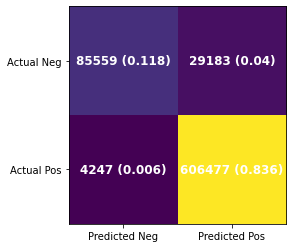

Rates: TNR: 0.75 | TPR: 0.99 | FNR: 0.01 | FPR: 0.25

Performance on testing data:
Accuracy: 0.951
Precision: 0.952
Recall: 0.992
F1 Score: 0.971
F2 Score: 0.984
Confusion Matrix:


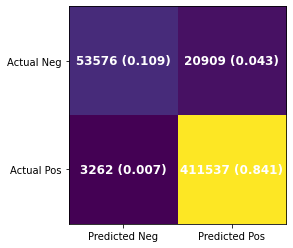

Rates: TNR: 0.72 | TPR: 0.99 | FNR: 0.01 | FPR: 0.28


In [ ]:
# Obtain best features and hyperparameters
space_LR = {'sfm__estimator__alpha': [0.001, 0.01, 0.1],
            'clf__penalty': ['l1', 'l2']}
Xtrain_new, Xtest_new, results = tuning(X_train_scaled, y_train, X_test_scaled, y_test, space_LR, LR(solver = 'liblinear', max_iter = 4000, random_state = 42))

# Fit model with optimal hyperparameters, and predict on testing data
classifier = LR(penalty = results['clf__penalty'], solver = 'liblinear', max_iter = 4000, random_state = 42).fit(Xtrain_new, y_train)
resids_train = get_metrics(y_train.values, classifier.predict(Xtrain_new), 'training')
resids_test = get_metrics(y_test.values, classifier.predict(Xtest_new), 'testing')
full_test['LR Residuals'] = resids_test

## Naive Bayes
*based on Bayes Theorem, which updates our prior probabilistic belief to train a probability-based model for classifying inputs.*

GaussianNB
Best hyperparameters:  {'sfm__estimator__alpha': 0.01}
Features: ['mba_days_delinquent' 'mba_worst_ever' 'year' 'initial_interest_rate'
 'fico_score_at_origination']
Shape of training set before/after FS: (725466, 62) -> (725466, 5) 
Shape of testing set before/after FS: (489284, 62) -> (489284, 5)

Performance on training data:
Accuracy: 0.946
Precision: 0.961
Recall: 0.975
F1 Score: 0.968
F2 Score: 0.972
Confusion Matrix:


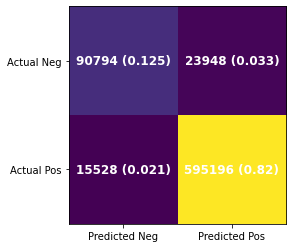

Rates: TNR: 0.79 | TPR: 0.97 | FNR: 0.03 | FPR: 0.21

Performance on testing data:
Accuracy: 0.943
Precision: 0.96
Recall: 0.973
F1 Score: 0.967
F2 Score: 0.971
Confusion Matrix:


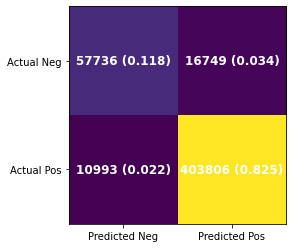

Rates: TNR: 0.78 | TPR: 0.97 | FNR: 0.03 | FPR: 0.22


In [ ]:
# Obtain best features and hyperparameters
space_NB = {'sfm__estimator__alpha': [0.001, 0.01]}
Xtrain_new, Xtest_new, results = tuning(X_train_scaled, y_train, X_test_scaled, y_test, space_NB, NB())

# Fit model with optimal hyperparameters, and predict on testing data
classifier = NB().fit(Xtrain_new, y_train)
resids_train = get_metrics(y_train.values, classifier.predict(Xtrain_new), 'training')
resids_test = get_metrics(y_test.values, classifier.predict(Xtest_new), 'testing')
full_test['NB Residuals'] = resids_test

## Decision Tree

*flowchart that uses choices to subdivide data (in the feature space) into successively refined groups.*

DecisionTreeClassifier
Best hyperparameters:  {'clf__criterion': 'entropy', 'clf__max_depth': 10, 'sfm__estimator__alpha': 0.01}
Features: ['mba_days_delinquent' 'mba_worst_ever' 'year' 'initial_interest_rate'
 'fico_score_at_origination']
Shape of training set before/after FS: (725466, 62) -> (725466, 5) 
Shape of testing set before/after FS: (489284, 62) -> (489284, 5)

Performance on training data:
Accuracy: 0.966
Precision: 0.977
Recall: 0.982
F1 Score: 0.98
F2 Score: 0.981
Confusion Matrix:


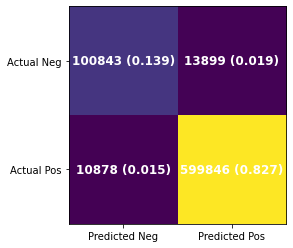

Rates: TNR: 0.88 | TPR: 0.98 | FNR: 0.02 | FPR: 0.12

Performance on testing data:
Accuracy: 0.96
Precision: 0.976
Recall: 0.977
F1 Score: 0.977
F2 Score: 0.977
Confusion Matrix:


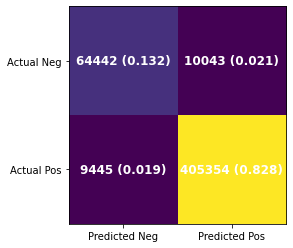

Rates: TNR: 0.87 | TPR: 0.98 | FNR: 0.02 | FPR: 0.13


In [ ]:
# Obtain best features and hyperparameters
space_DT = {'sfm__estimator__alpha': [0.001, 0.01],
            'clf__criterion': ['gini', 'entropy'],
            'clf__max_depth': [10, None]}
Xtrain_new, Xtest_new, results = tuning(X_train_scaled, y_train, X_test_scaled, y_test, space_DT, DT(random_state = 42))

# Fit model with optimal hyperparameters, and predict on testing data
classifier = DT(criterion = results['clf__criterion'], max_depth = results['clf__max_depth'], random_state = 42).fit(Xtrain_new, y_train)
resids_train = get_metrics(y_train.values, classifier.predict(Xtrain_new), 'training')
resids_test = get_metrics(y_test.values, classifier.predict(Xtest_new), 'testing')
full_test['DT Residuals'] = resids_test

## Random Forest
*an ensemble model based on a collection of decision trees.*

RandomForestClassifier
Best hyperparameters:  {'clf__criterion': 'entropy', 'sfm__estimator__alpha': 0.01}
Features: ['mba_days_delinquent' 'mba_worst_ever' 'year' 'initial_interest_rate'
 'fico_score_at_origination']
Shape of training set before/after FS: (725466, 62) -> (725466, 5) 
Shape of testing set before/after FS: (489284, 62) -> (489284, 5)

Performance on training data:
Accuracy: 0.975
Precision: 0.98
Recall: 0.991
F1 Score: 0.985
F2 Score: 0.989
Confusion Matrix:


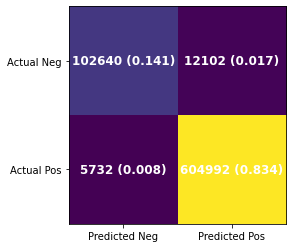

Rates: TNR: 0.89 | TPR: 0.99 | FNR: 0.01 | FPR: 0.11

Performance on testing data:
Accuracy: 0.947
Precision: 0.966
Recall: 0.972
F1 Score: 0.969
F2 Score: 0.971
Confusion Matrix:


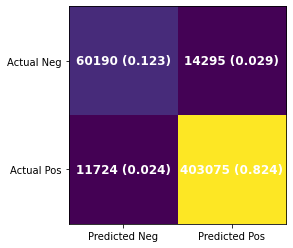

Rates: TNR: 0.81 | TPR: 0.97 | FNR: 0.03 | FPR: 0.19


In [ ]:
# Obtain best features and hyperparameters
space_RF = {'sfm__estimator__alpha': [0.001, 0.01],
            'clf__criterion': ['gini', 'entropy']}
Xtrain_new, Xtest_new, results = tuning(X_train_scaled, y_train, X_test_scaled, y_test, space_RF, RF(max_depth = 100, n_jobs = -1, random_state = 42))

# Fit model with optimal hyperparameters, and predict on testing data
classifier = RF(criterion = results['clf__criterion'], max_depth = 100, n_jobs = -1, random_state = 42).fit(Xtrain_new, y_train)
resids_train = get_metrics(y_train.values, classifier.predict(Xtrain_new), 'training')
resids_test = get_metrics(y_test.values, classifier.predict(Xtest_new), 'testing')
full_test['RF Residuals'] = resids_test

## MLP

MLPClassifier


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning:

Training interrupted by user.



Best hyperparameters:  {'clf__activation': 'relu', 'clf__hidden_layer_sizes': (40,), 'clf__learning_rate': 'constant', 'sfm__estimator__alpha': 0.01}
Features: ['mba_days_delinquent' 'mba_worst_ever' 'year' 'initial_interest_rate'
 'fico_score_at_origination']
Shape of training set before/after FS: (725466, 82) -> (725466, 5) 
Shape of testing set before/after FS: (489284, 82) -> (489284, 5)

Performance on training data:
Accuracy: 0.965
Precision: 0.978
Recall: 0.981
F1 Score: 0.979
F2 Score: 0.98
Confusion Matrix:


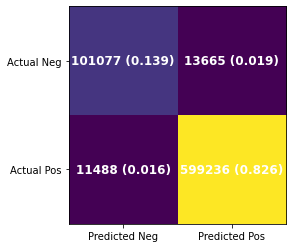

Rates: TNR: 0.88 | TPR: 0.98 | FNR: 0.02 | FPR: 0.12

Performance on testing data:
Accuracy: 0.963
Precision: 0.977
Recall: 0.98
F1 Score: 0.978
F2 Score: 0.979
Confusion Matrix:


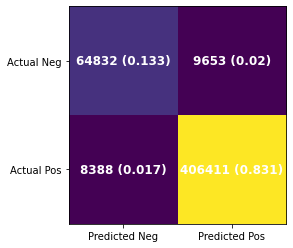

Rates: TNR: 0.87 | TPR: 0.98 | FNR: 0.02 | FPR: 0.13


In [ ]:
# Obtain best features and hyperparameters
space_MLP = {'sfm__estimator__alpha': [0.001, 0.01],
            'clf__hidden_layer_sizes': [(20,), (40,)],
            'clf__activation': ['tanh', 'relu'],
            'clf__learning_rate': ['constant','adaptive']}
Xtrain_new, Xtest_new, results = tuning(X_train_scaled, y_train, X_test_scaled, y_test, space_MLP, MLP(random_state = 42))

# Fit model with optimal hyperparameters, and predict on testing data
classifier = MLP(hidden_layer_sizes = results['clf__hidden_layer_sizes'], 
                 activation = results['clf__activation'], 
                 learning_rate = results['clf__learning_rate'], 
                 max_iter=10000).fit(Xtrain_new, y_train)
resids_train = get_metrics(y_train.values, classifier.predict(Xtrain_new), 'training')
resids_test = get_metrics(y_test.values, classifier.predict(Xtest_new), 'testing')
full_test['MLP Residuals'] = resids_test

# Analysis

In [ ]:
# incorrect_df = full_test[full_test["DT Residuals"] == 1]
# all_df = full_test.copy()

# incorrect_df.groupby(['mba_worst_ever']).count() / full_test.groupby(['mba_worst_ever']).count()

# incorrect_df.groupby(['year']).count() / full_test.groupby(['year']).count()

# incorrect_df.groupby(['loan_age']).count() / full_test.groupby(['loan_age']).count()

# incorrect_df.groupby(['gse_eligible_flag']).count() / full_test.groupby(['gse_eligible_flag']).count()

# incorrect_df.groupby(['product_type']).count() / full_test.groupby(['product_type']).count()

# all_df['qcut'] = pd.qcut(all_df['original_ltv'], q=4).values
# incorrect_df['qcut'] = all_df.loc[all_df["LR Residuals"] == 1, 'qcut']
# incorrect_df.groupby(['qcut']).count() / all_df.groupby(['qcut']).count() 

# incorrect_df['qcut'] = pd.qcut(incorrect_df['loan_age'], q=4).values
# all_df['qcut'] = pd.qcut(all_df['loan_age'], q=4).values
# incorrect_df.groupby(['qcut']).count() / all_df.groupby(['qcut']).count() 

# incorrect_df['qcut'] = pd.qcut(incorrect_df['fico_score_at_origination'], q=4).values
# all_df['qcut'] = pd.cut(all_df['fico_score_at_origination'], incorrect_df['qcut'].unique()).values
# incorrect_df.groupby(['qcut']).count() / all_df.groupby(['qcut']).count() 